In [1]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation
plt.style.use('dark_background')

tau = 2 * np.pi

In [2]:
import sys
sys.path.append('../')

In [3]:
from modules.data_utils import parse_svg

points = parse_svg('../data/fourier.svg')
# Make it centered around the origin (optional).
points -= points.mean()

paths:   0%|          | 0/1 [00:00<?, ?it/s]

time:   0%|          | 0/1001 [00:00<?, ?it/s]

## Using numpy's Fast Fourier Transform

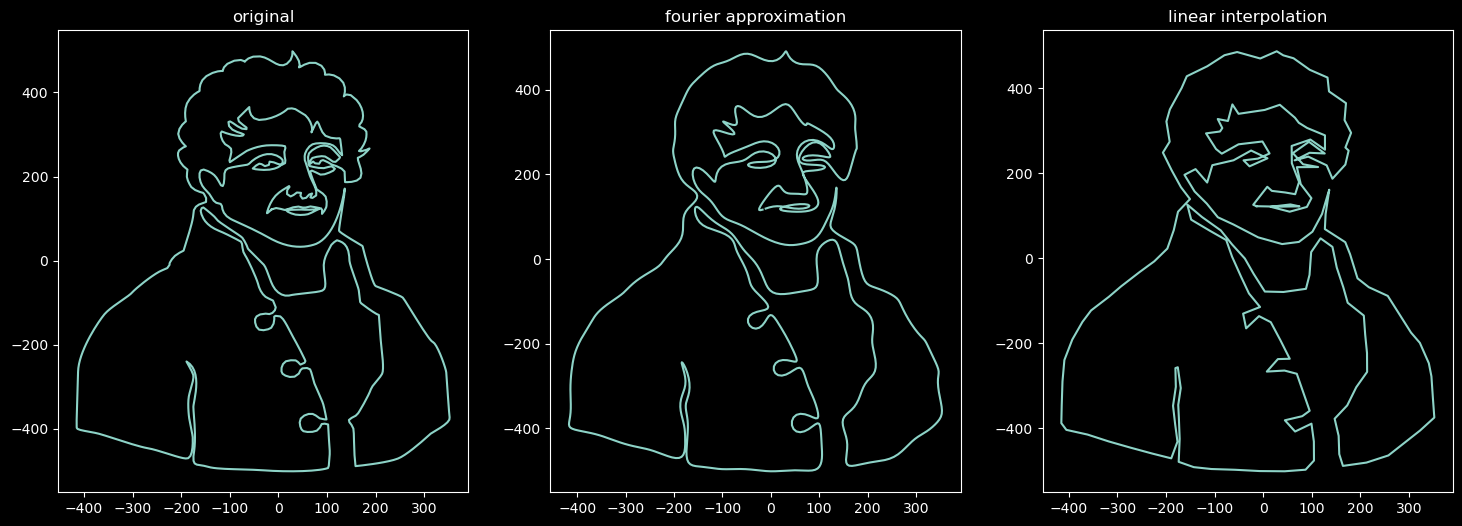

In [4]:
num_coeffs = None  # Would be taken as len(points) if None is passed.
coeffs = np.fft.fft(points, n=num_coeffs)
num_coeffs = len(coeffs)

def inv_FFT(coeffs: np.ndarray, num_coeffs: int) -> np.ndarray:
  '''Zero out the lesser contributing coeffs so that curve length remains the same,
  and we get a smooth approximation.'''
  indices = np.arange(num_coeffs)  #  0,  1,  2,  3,  4, ...
  signs = 2*(indices % 2) - 1      # -1,  1, -1,  1, -1, ...
  magnitudes = (indices + 1) // 2  #  0,  1,  1,  2,  2, ...
  sequence = signs * magnitudes    #  0,  1, -1,  2, -2, ...
  coeffs_partial = np.zeros_like(coeffs)
  coeffs_partial[sequence] = coeffs[sequence]
  points_appr = np.fft.ifft(coeffs_partial)
  return points_appr


n_pts_approx = 201
fig, axs = plt.subplots(1,3, figsize=(18,6))
axs[0].plot(points.real, points.imag)
axs[0].set_title('original')
points_appr = inv_FFT(coeffs, n_pts_approx)
axs[1].plot(points_appr.real, points_appr.imag)
axs[1].set_title('fourier approximation')
points_appr = np.interp(np.linspace(0,len(points), n_pts_approx),
                        range(len(points)), points)
axs[2].plot(points_appr.real, points_appr.imag)
axs[2].set_title('linear interpolation')
plt.show()

In [6]:
points_apprs = {}
num_coeffs = 201

indices = np.arange(num_coeffs)  #  0,  1,  2,  3,  4, ...
signs = 2*(indices % 2) - 1      # -1,  1, -1,  1, -1, ...
magnitudes = (indices + 1) // 2  #  0,  1,  1,  2,  2, ...
sequence = signs * magnitudes    #  0,  1, -1,  2, -2, ...
coeffs_partial = np.zeros_like(coeffs)

for n in tqdm(range(1,1+num_coeffs)):
  coeffs_partial[sequence[:n]] = coeffs[sequence[:n]]
  points_apprs[n] = np.fft.ifft(coeffs_partial)

points_apprs = np.array(list(points_apprs.values()))

  0%|          | 0/201 [00:00<?, ?it/s]

### Evolution animation

In [6]:
from celluloid import Camera

In [7]:
fig, ax = plt.subplots()
camera = Camera(fig)
plt.axis('off')

for num_coeffs, points_appr in enumerate(tqdm(points_apprs, desc='generating evolution animation'), 1):
  plt.plot(points_appr.real, points_appr.imag, c='y')
  plt.text(0.4, 1.05, f'num coeffs: {num_coeffs}', transform = ax.transAxes)
  camera.snap()
plt.close(fig)  
  
anim = camera.animate()
FFwriter = animation.FFMpegWriter(fps=1)
anim.save(f"../animations/evolution.mp4", writer=FFwriter, dpi=300)

generating evolution animation:   0%|          | 0/201 [00:00<?, ?it/s]

### Widget

In [79]:
from matplotlib.widgets import Slider, CheckButtons, RadioButtons
from matplotlib.backend_bases import MouseButton

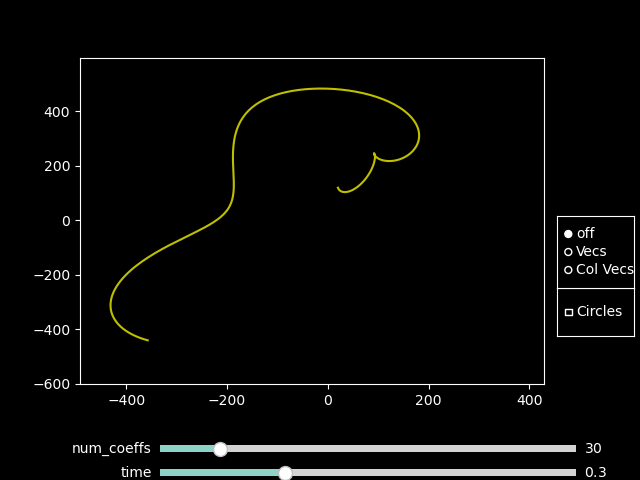

In [116]:
%matplotlib ipympl
fig, axs = plt.subplots()
plt.subplots_adjust(bottom=0.2, right=0.85)
# plt.plot(points.real, points.imag, alpha=0.3)
x_pad = 0.1 * (points.real.max() - points.real.min())
y_pad = 0.1 * (points.imag.max() - points.imag.min())
axs.set_xlim(points.real.min() - x_pad, points.real.max() + x_pad)
axs.set_ylim(points.imag.min() - y_pad, points.imag.max() + y_pad)

time = .3
num_coeffs = 30
max_coeffs, max_points = points_apprs.shape

n_circle_pts = 36
curve, = plt.plot([], [], c='y')
circle_vectors, = plt.plot([], [], c='w')
circle_vectors_pos, = plt.plot([], [], c='b')
circle_vectors_neg, = plt.plot([], [], c='r')
circle_centers, = plt.plot([], [], alpha=0.3)
constant_vector = plt.scatter(points_apprs[0,0].real,
                              points_apprs[0,0].imag,
                              c='w', visible=False)


# Define the function to update the plot based on interaction.
def update_plot_data():
  # Draw the curve.
  time_points = int(time*(max_points-1))
  curve_appr = points_apprs[num_coeffs-1, :time_points+1]
  curve.set_data(curve_appr.real, curve_appr.imag)

  # Draw the rotating vectors.
  if not radio_buttons.value_selected == 'off':
    constant_vector.set_visible(True)
    vectors_appr = points_apprs[:num_coeffs, time_points]
    if radio_buttons.value_selected == 'Col Vecs':
      if num_coeffs > 1:
        vectors_appr_pos = np.full(num_coeffs + num_coeffs//2, np.nan+0j)
        vectors_appr_neg = np.full(num_coeffs + num_coeffs//2 - 2, np.nan+0j)
        vectors_appr_pos[::3] = vectors_appr[::2]
        vectors_appr_pos[1::3] = vectors_appr[1::2]
        vectors_appr_neg[::3] = vectors_appr[1::2]
        vectors_appr_neg[1::3] = vectors_appr[2::2]
        circle_vectors_pos.set_data(vectors_appr_pos.real, vectors_appr_pos.imag)
        circle_vectors_neg.set_data(vectors_appr_neg.real, vectors_appr_neg.imag)
      else:
        circle_vectors_pos.set_data([], [])
        circle_vectors_neg.set_data([], [])
      circle_vectors.set_data([], [])
    elif radio_buttons.value_selected == 'Vecs':
      circle_vectors.set_data(vectors_appr.real, vectors_appr.imag)
      circle_vectors_pos.set_data([], [])
      circle_vectors_neg.set_data([], [])
  else:
    constant_vector.set_visible(False)
    circle_vectors.set_data([], [])
    circle_vectors_pos.set_data([], [])
    circle_vectors_neg.set_data([], [])
  
  # Draw the circles.
  if check_buttons.get_status()[0]:
    vectors_appr = np.insert(vectors_appr, 0, 0)
    radii = abs(np.diff(vectors_appr))
    circles = np.full((2*len(radii), n_circle_pts), np.nan).astype(complex)
    circles[::2] = (vectors_appr[:-1][:, None] +
                    radii[:,None] * np.exp(1j*np.linspace(0,tau,n_circle_pts)))
    circles = circles.ravel()
    circle_centers.set_data(circles.real, circles.imag)
  else:
    circle_centers.set_data([], [])


# Define the sliders.
ax_CoeffsSlider = plt.axes([0.25, 0.05, 0.65, 0.03])
Coeffs_slider = Slider(ax_CoeffsSlider, 'num_coeffs',
                       1, max_coeffs, valinit=num_coeffs, valstep=1)
def update_coeffs(num_coeffs_updated):
  global num_coeffs
  num_coeffs = num_coeffs_updated
  update_plot_data()
Coeffs_slider.on_changed(update_coeffs)

ax_TimeSlider = plt.axes([0.25, 0.0, 0.65, 0.03])
Time_slider = Slider(ax_TimeSlider, 'time',
                     0, 1, valinit=time, valstep=1e-4)
def update_time(time_updated):
  global time
  time = time_updated
  update_plot_data()
Time_slider.on_changed(update_time)


# Define the check buttons and radio buttons.
ax_CheckButtons = plt.axes([0.87, 0.3, 0.12, 0.1])
check_buttons = CheckButtons(ax_CheckButtons, ['Circles'],
                             frame_props={'edgecolor': 'w'},
                             check_props={'facecolor': 'w'})
ax_RadioButtons = plt.axes([0.87, 0.4, 0.12, 0.15])
radio_buttons = RadioButtons(ax_RadioButtons, ['off', 'Vecs', 'Col Vecs'],
                             radio_props={'edgecolor': 'w', 'facecolor': 'w'})
radio_buttons.on_clicked(lambda label: update_plot_data())


# Initual plot with the params defined at the top.
update_plot_data()
plt.show()

In [115]:
plt.close()